Loading image from scrambled_lena.mat...
Image split into 4x4 = 16 pieces
Piece dimensions: 128x128

Starting puzzle solving...

=== Start 1/3 ===
Iter 0, Cost: 35356.51, Best: 34243.07, Temp: 3105.4009, Accept rate: 100.00%
Iter 500, Cost: 24551.64, Best: 24387.04, Temp: 253.3133, Accept rate: 11.00%
Iter 1000, Cost: 17209.81, Best: 17209.81, Temp: 20.6632, Accept rate: 0.00%
Iter 1500, Cost: 16722.41, Best: 16722.41, Temp: 1.6855, Accept rate: 0.00%
Reheating at iteration 1539, temp: 1560.50
Iter 2000, Cost: 22353.30, Best: 16722.41, Temp: 154.0025, Accept rate: 5.00%
Reheating at iteration 2040, temp: 1560.50
Iter 2500, Cost: 22032.23, Best: 16722.41, Temp: 154.7764, Accept rate: 5.00%
Reheating at iteration 2541, temp: 1560.50
Iter 3000, Cost: 20278.97, Best: 16722.41, Temp: 155.5542, Accept rate: 6.00%
Iter 3500, Cost: 19152.85, Best: 16722.41, Temp: 12.6888, Accept rate: 1.00%
Iter 4000, Cost: 19152.85, Best: 16722.41, Temp: 1.0351, Accept rate: 0.00%
Iter 4500, Cost: 19080.79, B

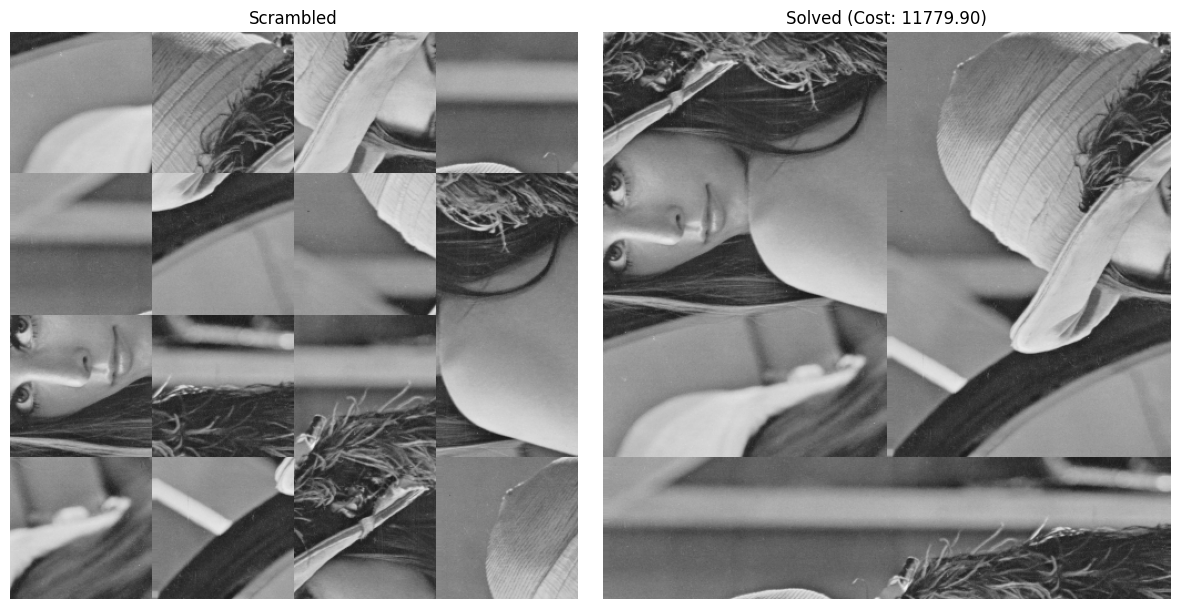

In [22]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import math
from collections import deque

def load_and_split_image(mat_path, grid_size, var_name='Iscrambled'):
    """Load image from .mat file and split into puzzle pieces."""
    with open(mat_path, 'r') as f:
        lines = f.readlines()
    
    # Skip the first line (creation comment)
    header_lines = lines[1:5]
    data_lines = lines[5:]
    
    # Parse header
    name_line = header_lines[0].strip()
    if not name_line.startswith('# name:'):
        raise ValueError("Invalid .mat file format")
    actual_var_name = name_line.split(': ')[1]
    if actual_var_name != var_name:
        print(f"Warning: Expected {var_name}, found {actual_var_name}")
    
    type_line = header_lines[1].strip()
    if not type_line.startswith('# type:'):
        raise ValueError("Invalid .mat file format")
    
    ndims_line = header_lines[2].strip()
    if not ndims_line.startswith('# ndims:'):
        raise ValueError("Invalid .mat file format")
    ndims = int(ndims_line.split(': ')[1])
    
    dims_line = header_lines[3].strip()
    dims = list(map(int, dims_line.split()))
    if ndims == 2:
        height, width = dims
    else:
        raise ValueError("Only 2D matrices supported")
    
    # Parse data
    data_flat = []
    for line in data_lines:
        if line.strip():
            data_flat.extend(map(int, line.strip().split()))
    
    img_array = np.array(data_flat, dtype=np.uint8).reshape((height, width))
    # Convert grayscale to RGB
    img_array = np.stack([img_array] * 3, axis=-1)
    
    piece_height = height // grid_size
    piece_width = width // grid_size
    pieces = []
    for i in range(grid_size):
        for j in range(grid_size):
            top = i * piece_height
            left = j * piece_width
            piece = img_array[top:top+piece_height, left:left+piece_width, :]
            pieces.append(piece)
    return pieces, piece_width, piece_height, grid_size

def get_oriented_piece(piece, orientation):
    """Apply orientation to a piece (0=normal, 1=flipped)."""
    if orientation == 0:
        return piece
    else:
        return np.flipud(piece)

def compute_edge_dissimilarity(piece1, piece2, direction):
    """Compute dissimilarity between adjacent edges using L2 norm."""
    if direction == 'right':
        edge1 = piece1[:, -1, :].flatten()
        edge2 = piece2[:, 0, :].flatten()
    elif direction == 'bottom':
        edge1 = piece1[-1, :, :].flatten()
        edge2 = piece2[0, :, :].flatten()
    else:
        return 0
    
    # Use L2 norm for better gradient information
    diff = edge1.astype(np.float32) - edge2.astype(np.float32)
    return np.sqrt(np.sum(diff ** 2))

def compute_corner_bonus(state, original_pieces, grid_size):
    """Give bonus for matching corners between 4 adjacent pieces."""
    bonus = 0
    for i in range(grid_size - 1):
        for j in range(grid_size - 1):
            # Get 4 pieces at corner
            tl_idx = i * grid_size + j
            tr_idx = i * grid_size + j + 1
            bl_idx = (i + 1) * grid_size + j
            br_idx = (i + 1) * grid_size + j + 1
            
            tl_piece = get_oriented_piece(original_pieces[state[tl_idx][0]], state[tl_idx][1])
            tr_piece = get_oriented_piece(original_pieces[state[tr_idx][0]], state[tr_idx][1])
            bl_piece = get_oriented_piece(original_pieces[state[bl_idx][0]], state[bl_idx][1])
            br_piece = get_oriented_piece(original_pieces[state[br_idx][0]], state[br_idx][1])
            
            # Check corner pixels
            corner_pixels = [
                tl_piece[-1, -1, :],
                tr_piece[-1, 0, :],
                bl_piece[0, -1, :],
                br_piece[0, 0, :]
            ]
            
            # Compute variance - lower is better
            corner_array = np.array(corner_pixels)
            variance = np.var(corner_array, axis=0).sum()
            bonus += variance
    
    return bonus

def cost_function(state, original_pieces, grid_size, use_corners=True):
    """Enhanced cost function with edge matching and corner bonuses."""
    total_cost = 0
    idx = 0
    
    for i in range(grid_size):
        for j in range(grid_size):
            piece_idx, orient = state[idx]
            current_piece = get_oriented_piece(original_pieces[piece_idx], orient)
            
            # Right neighbor
            if j < grid_size - 1:
                right_idx = idx + 1
                right_piece_idx, right_orient = state[right_idx]
                right_piece = get_oriented_piece(original_pieces[right_piece_idx], right_orient)
                total_cost += compute_edge_dissimilarity(current_piece, right_piece, 'right')
            
            # Bottom neighbor
            if i < grid_size - 1:
                bottom_idx = idx + grid_size
                bottom_piece_idx, bottom_orient = state[bottom_idx]
                bottom_piece = get_oriented_piece(original_pieces[bottom_piece_idx], bottom_orient)
                total_cost += compute_edge_dissimilarity(current_piece, bottom_piece, 'bottom')
            
            idx += 1
    
    # Add corner bonus
    if use_corners:
        total_cost += compute_corner_bonus(state, original_pieces, grid_size) * 0.1
    
    return total_cost

def generate_neighbor(current_state, move_type='adaptive'):
    """Generate neighbor states with various move strategies."""
    new_state = [item for item in current_state]
    num_pieces = len(current_state)
    
    if move_type == 'adaptive':
        # Adaptive move selection
        rand = random.random()
        if rand < 0.4:  # Simple swap
            idx1, idx2 = random.sample(range(num_pieces), 2)
            new_state[idx1], new_state[idx2] = new_state[idx2], new_state[idx1]
        elif rand < 0.6:  # Chain swap (3 pieces)
            indices = random.sample(range(num_pieces), min(3, num_pieces))
            values = [new_state[i] for i in indices]
            rotated = values[1:] + [values[0]]
            for i, idx in enumerate(indices):
                new_state[idx] = rotated[i]
        elif rand < 0.8:  # Block rotation (2x2 block if possible)
            grid_size = int(np.sqrt(num_pieces))
            if grid_size > 2:
                i = random.randint(0, grid_size - 2)
                j = random.randint(0, grid_size - 2)
                # Rotate 2x2 block clockwise
                tl = i * grid_size + j
                tr = i * grid_size + j + 1
                bl = (i + 1) * grid_size + j
                br = (i + 1) * grid_size + j + 1
                temp = new_state[tl]
                new_state[tl] = new_state[bl]
                new_state[bl] = new_state[br]
                new_state[br] = new_state[tr]
                new_state[tr] = temp
            else:
                # Fallback to simple swap
                idx1, idx2 = random.sample(range(num_pieces), 2)
                new_state[idx1], new_state[idx2] = new_state[idx2], new_state[idx1]
        elif rand < 0.95:  # Multiple swaps
            num_swaps = random.randint(2, 4)
            for _ in range(num_swaps):
                idx1, idx2 = random.sample(range(num_pieces), 2)
                new_state[idx1], new_state[idx2] = new_state[idx2], new_state[idx1]
        else:  # Flip orientation
            idx = random.randint(0, num_pieces - 1)
            piece_idx, orient = new_state[idx]
            new_state[idx] = (piece_idx, 1 - orient)
    
    return new_state

def adaptive_simulated_annealing(initial_state, original_pieces, grid_size, 
                                max_iter=10000, initial_temp=None):
    """Enhanced simulated annealing with adaptive parameters."""
    current_state = [item for item in initial_state]
    current_cost = cost_function(current_state, original_pieces, grid_size)
    
    # Adaptive initial temperature
    if initial_temp is None:
        # Sample random moves to estimate cost landscape
        sample_costs = []
        for _ in range(50):
            sample_state = generate_neighbor(current_state)
            sample_cost = cost_function(sample_state, original_pieces, grid_size)
            sample_costs.append(abs(sample_cost - current_cost))
        initial_temp = np.mean(sample_costs) * 2
    
    best_state = [item for item in current_state]
    best_cost = current_cost
    
    # Temperature schedule parameters
    cooling_rate = 0.995  # Geometric cooling
    min_temp = 0.001
    
    # Tracking for adaptive moves
    accept_history = deque(maxlen=100)
    stuck_counter = 0
    last_improvement = 0
    
    temp = initial_temp
    
    for iteration in range(max_iter):
        # Adaptive temperature reheating if stuck
        if iteration - last_improvement > 500 and stuck_counter < 3:
            temp = initial_temp * 0.5  # Reheat
            stuck_counter += 1
            last_improvement = iteration
            print(f"Reheating at iteration {iteration}, temp: {temp:.2f}")
        
        # Generate neighbor with adaptive strategy
        new_state = generate_neighbor(current_state, 'adaptive')
        new_cost = cost_function(new_state, original_pieces, grid_size)
        
        delta = new_cost - current_cost
        
        # Metropolis acceptance criterion
        if delta < 0:
            accept = True
        else:
            accept_prob = math.exp(-delta / temp)
            accept = random.random() < accept_prob
        
        if accept:
            current_state = new_state
            current_cost = new_cost
            accept_history.append(1)
            
            if current_cost < best_cost:
                best_state = [item for item in current_state]
                best_cost = current_cost
                last_improvement = iteration
        else:
            accept_history.append(0)
        
        # Cool down temperature
        temp = max(min_temp, temp * cooling_rate)
        
        # Progress logging
        if iteration % 500 == 0:
            accept_rate = np.mean(accept_history) if len(accept_history) > 0 else 0
            print(f"Iter {iteration}, Cost: {current_cost:.2f}, Best: {best_cost:.2f}, "
                  f"Temp: {temp:.4f}, Accept rate: {accept_rate:.2%}")
        
        # Early stopping if solved
        if best_cost < 1.0:
            print(f"Solution found at iteration {iteration}!")
            break
    
    return best_state

def multi_start_solve(original_pieces, grid_size, num_starts=3):
    """Multiple random starts to avoid local minima."""
    num_pieces = grid_size * grid_size
    best_overall_state = None
    best_overall_cost = float('inf')
    
    for start in range(num_starts):
        print(f"\n=== Start {start + 1}/{num_starts} ===")
        
        # Random initial state
        if start == 0:
            # First run: completely random
            initial_state = [(i, 0) for i in range(num_pieces)]
            random.shuffle(initial_state)
        else:
            # Subsequent runs: smart initialization based on edge matching
            initial_state = smart_initialization(original_pieces, grid_size)
        
        # Run simulated annealing
        solved_state = adaptive_simulated_annealing(
            initial_state, original_pieces, grid_size
        )
        
        final_cost = cost_function(solved_state, original_pieces, grid_size)
        print(f"Start {start + 1} final cost: {final_cost:.2f}")
        
        if final_cost < best_overall_cost:
            best_overall_cost = final_cost
            best_overall_state = solved_state
    
    return best_overall_state

def smart_initialization(pieces, grid_size):
    """Create a smarter initial state based on edge similarity."""
    num_pieces = len(pieces)
    used = [False] * num_pieces
    state = []
    
    # Start with a random piece in top-left
    first_idx = random.randint(0, num_pieces - 1)
    state.append((first_idx, 0))
    used[first_idx] = True
    
    # Greedy placement for remaining pieces
    for pos in range(1, num_pieces):
        best_piece = None
        best_cost = float('inf')
        
        for piece_idx in range(num_pieces):
            if used[piece_idx]:
                continue
            
            # Try this piece in current position
            temp_state = state + [(piece_idx, 0)]
            
            # Only compute cost for edges connecting to already placed pieces
            local_cost = 0
            row = pos // grid_size
            col = pos % grid_size
            
            # Check left neighbor
            if col > 0 and pos - 1 < len(state):
                left_piece_idx = state[pos - 1][0]
                left_piece = pieces[left_piece_idx]
                current_piece = pieces[piece_idx]
                local_cost += compute_edge_dissimilarity(left_piece, current_piece, 'right')
            
            # Check top neighbor
            if row > 0 and pos - grid_size < len(state):
                top_piece_idx = state[pos - grid_size][0]
                top_piece = pieces[top_piece_idx]
                current_piece = pieces[piece_idx]
                local_cost += compute_edge_dissimilarity(top_piece, current_piece, 'bottom')
            
            if local_cost < best_cost:
                best_cost = local_cost
                best_piece = piece_idx
        
        state.append((best_piece, 0))
        used[best_piece] = True
    
    return state

def reconstruct_image(state, original_pieces, grid_size, piece_width, piece_height):
    """Reconstruct the full image from puzzle state."""
    img_array = np.zeros((grid_size * piece_height, grid_size * piece_width, 3), dtype=np.uint8)
    idx = 0
    for i in range(grid_size):
        for j in range(grid_size):
            piece_idx, orient = state[idx]
            piece = get_oriented_piece(original_pieces[piece_idx], orient)
            img_array[i*piece_height:(i+1)*piece_height, j*piece_width:(j+1)*piece_width] = piece
            idx += 1
    return Image.fromarray(img_array)

def main(mat_path, grid_size=4, var_name='Iscrambled', use_multi_start=True):
    """Main function to solve the jigsaw puzzle."""
    print(f"Loading image from {mat_path}...")
    original_pieces, pw, ph, gs = load_and_split_image(mat_path, grid_size, var_name)
    
    print(f"Image split into {gs}x{gs} = {len(original_pieces)} pieces")
    print(f"Piece dimensions: {pw}x{ph}")
    
    # Create initial scrambled state for visualization
    num_pieces = gs * gs
    scrambled_state = [(i, 0) for i in range(num_pieces)]
    random.shuffle(scrambled_state)
    
    print("\nStarting puzzle solving...")
    
    if use_multi_start:
        solved_state = multi_start_solve(original_pieces, gs)
    else:
        solved_state = adaptive_simulated_annealing(scrambled_state, original_pieces, gs)
    
    # Calculate final cost
    final_cost = cost_function(solved_state, original_pieces, gs)
    print(f"\n=== FINAL RESULT ===")
    print(f"Final solved cost: {final_cost:.2f}")
    
    # Reconstruct images
    initial_img = reconstruct_image(scrambled_state, original_pieces, gs, pw, ph)
    final_img = reconstruct_image(solved_state, original_pieces, gs, pw, ph)
    
    # Display results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(initial_img)
    ax1.set_title('Scrambled')
    ax1.axis('off')
    ax2.imshow(final_img)
    ax2.set_title(f'Solved (Cost: {final_cost:.2f})')
    ax2.axis('off')
    plt.tight_layout()
    plt.show()
    
    return solved_state, final_cost

if __name__ == "__main__":
    # Run with enhanced algorithm
    solved_state, cost = main('scrambled_lena.mat', grid_size=4, use_multi_start=True)